In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]
import numpy as np
import keras
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil
import matplotlib.patches as patches
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [3]:
base_path = "D:/FileDownload/caltech-101/caltech-101"

# Đường dẫn đúng cần hai lần lặp "101_ObjectCategories"
obj_path = os.path.join(base_path, "101_ObjectCategories/101_ObjectCategories")
anota_path = os.path.join(base_path, "Annotations/Annotations")

# Lấy danh sách các thư mục ảnh và chú thích
image_categories = sorted(os.listdir(obj_path))  # Danh sách thư mục ảnh
annot_categories = sorted(os.listdir(anota_path))  # Danh sách thư mục chú thích

# Khởi tạo danh sách để lưu ảnh và targets
images = []
targets = []
matching_categories = []

image_size = 224  # Kích thước ảnh sau khi resize

# Duyệt qua từng thư mục ảnh
for category in image_categories:
    category_path = os.path.join(obj_path, category)
    
    if category in annot_categories:  # Nếu thư mục ảnh và chú thích trùng nhau
        print(f"Processing category: {category}")
        matching_categories.append(category)
        image_paths = sorted(
            [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
        )
        
        annot_category_path = os.path.join(anota_path, category)
        annot_paths = sorted(
            [f for f in os.listdir(annot_category_path) if os.path.isfile(os.path.join(annot_category_path, f))]
        )
        
        # Duyệt qua các ảnh trong thư mục
        for i in range(len(image_paths)):
            image_path = image_paths[i]
            annot_filename = f"annotation_{image_path.split('_')[1].split('.')[0]}.mat"
            
            if annot_filename in annot_paths:  # Kiểm tra xem có tệp chú thích tương ứng không
                annot_path = os.path.join(annot_category_path, annot_filename)
                
                # Đọc dữ liệu annotation
                annot = scipy.io.loadmat(annot_path)["box_coord"][0]
                top_left_x, top_left_y = annot[2], annot[0]
                bottom_right_x, bottom_right_y = annot[3], annot[1]

                # Đọc ảnh
                image = keras.utils.load_img(os.path.join(category_path, image_path))
                (w, h) = image.size[:2]

                # Resize ảnh
                image_resized = image.resize((image_size, image_size))

                # Chuyển đổi ảnh thành mảng và thêm vào danh sách images
                images.append(keras.utils.img_to_array(image_resized))

                # Tính tỷ lệ và lưu bounding box vào list targets
                targets.append(
                    (
                        float(top_left_x) / w,
                        float(top_left_y) / h,
                        float(bottom_right_x) / w,
                        float(bottom_right_y) / h,
                        category  # Thêm category làm nhãn
                    )
                )
            else:
                print(f"No annotation found for {image_path}")

Processing category: Leopards
Processing category: Motorbikes
Processing category: accordion
Processing category: airplanes
Processing category: anchor
Processing category: ant
Processing category: barrel
Processing category: bass
Processing category: beaver
Processing category: binocular
Processing category: bonsai
Processing category: brain
Processing category: brontosaurus
Processing category: buddha
Processing category: butterfly
Processing category: camera
Processing category: cannon
Processing category: car_side
Processing category: ceiling_fan
Processing category: cellphone
Processing category: chair
Processing category: chandelier
Processing category: cougar_body
Processing category: cougar_face
Processing category: crab
Processing category: crayfish
Processing category: crocodile
Processing category: crocodile_head
Processing category: cup
Processing category: dalmatian
Processing category: dollar_bill
Processing category: dolphin
Processing category: dragonfly
Processing cate

In [4]:
num_matching_categories = len(matching_categories)
print(f"Total matching categories: {num_matching_categories}")

Total matching categories: 99


In [5]:
# Chia dữ liệu theo từng category 80%-20%
x_train, y_train, x_test, y_test = [], [], [], []

# Duyệt qua từng category và chia dữ liệu
for i, category in enumerate(image_categories):
    # Lấy dữ liệu của category
    category_images = []
    category_targets = []

    # Lọc ảnh và targets theo category
    for j in range(len(images)):
        if targets[j][-1] == category:  # Nếu nhãn là category hiện tại
            category_images.append(images[j])
            category_targets.append(targets[j])

    # Chia dữ liệu 80%-20% cho category này
    split_idx = int(len(category_images) * 0.8)

    x_train.extend(category_images[:split_idx])  # Dữ liệu train
    y_train.extend(category_targets[:split_idx])  # Labels train

    x_test.extend(category_images[split_idx:])   # Dữ liệu test
    y_test.extend(category_targets[split_idx:])  # Labels test

# Chuyển đổi danh sách thành numpy array
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

# Kiểm tra kết quả
print(f"Training data size: {x_train.shape}")
print(f"Testing data size: {x_test.shape}")

print(f"Training data size: {y_train.shape}")
print(f"Testing data size: {y_test.shape}")


Training data size: (6211, 224, 224, 3)
Testing data size: (1596, 224, 224, 3)
Training data size: (6211, 5)
Testing data size: (1596, 5)


In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [8]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [9]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images) #lấy thông tin tensor đầu vào dạng (batch_size,height,width,channels).
        batch_size = input_shape[0]     
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size) # chia ảnh thành các patch
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,                #Tổng số patch trong 1 ảnh
                self.patch_size * self.patch_size * channels, #Kích thước của patch sau khi làm phẳng
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Image size: 224 X 224
Patch size: 32 X 32
Patches per image: 49
Elements per patch: 3072


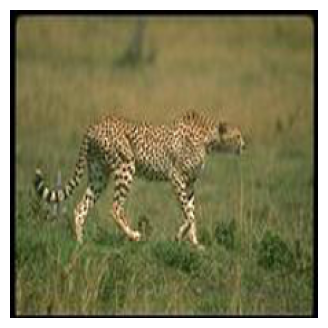

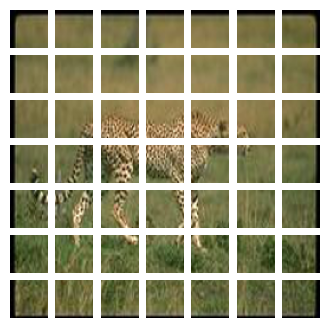

In [10]:
patch_size = 32  # Size of the patches to be extracted from the input images

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(np.expand_dims(x_train[0], axis=0))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [11]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

In [12]:
def create_vit_object_detector(input_shape, patch_size, num_patches, projection_dim, num_heads, transformer_units, transformer_layers, mlp_head_units, num_classes):
    """
    Tạo mô hình Vision Transformer (ViT) cho bài toán phân loại và xác định đối tượng.

    Args:
    - input_shape: Kích thước đầu vào của ảnh (height, width, channels).
    - patch_size: Kích thước của các patch.
    - num_patches: Số lượng patch (theo chiều dài hoặc chiều rộng của ảnh).
    - projection_dim: Kích thước của không gian vector khi chiếu các patch.
    - num_heads: Số lượng head trong MultiHead Attention.
    - transformer_units: Số lượng đơn vị trong mạng perceptron cho Transformer.
    - transformer_layers: Số lượng lớp Transformer.
    - mlp_head_units: Số lượng đơn vị trong MLP cuối cùng.
    - num_classes: Số lượng lớp phân loại.

    Returns:
    - model: Mô hình ViT vừa phân loại vừa xác định đối tượng.
    """
    
    inputs = keras.Input(shape=input_shape)

    # Augment data (nếu có)
    augmented = data_augmentation(inputs)

    # Tạo patches từ ảnh
    patches = Patches(patch_size)(augmented)
    
    # Encode patches bằng Patch Encoder
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Tạo nhiều lớp Transformer block
    for _ in range(transformer_layers):
        # Layer normalization
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # Multi-head Attention
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        
        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Layer normalization
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        
        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Lớp Normalize và Flatten
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    # Thêm MLP cho phần phân loại
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    # Tạo lớp phân loại (Classify outputs)
    logits = layers.Dense(num_classes)(features)

    # Tạo lớp xác định đối tượng (Bounding Box output)
    bounding_box = layers.Dense(4)(features)  # 4 values: x_min, y_min, x_max, y_max

    # Mô hình có hai đầu ra: phân loại (logits) và bounding box
    model = keras.Model(inputs=inputs, outputs=[logits, bounding_box])
    print(f"Logits shape: {logits.shape}")
    print(f"Bounding boxes shape: {bounding_box.shape}")
    return model


In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def run_experiment(model, x_train, y_train_class, y_train_bboxes, learning_rate, weight_decay, batch_size, num_epochs):
    """
    Hàm thực hiện quá trình huấn luyện mô hình ViT cho phân loại và xác định đối tượng.
    
    Args:
    - model: Mô hình ViT đã tạo.
    - x_train: Dữ liệu đầu vào cho huấn luyện (hình ảnh).
    - y_train_class: Nhãn phân loại của dữ liệu huấn luyện.
    - y_train_bboxes: Tọa độ bounding box của dữ liệu huấn luyện.
    - learning_rate: Tốc độ học của optimizer.
    - weight_decay: Mức độ điều chỉnh trọng số của optimizer.
    - batch_size: Kích thước batch.
    - num_epochs: Số lượng epoch huấn luyện.

    Returns:
    - history: Lịch sử huấn luyện của mô hình.
    """
    # Cài đặt optimizer với weight decay
    optimizer = Adam(learning_rate=learning_rate, weight_decay=weight_decay)

    # Compile model với custom loss function
    model.compile(optimizer=optimizer, loss=[SparseCategoricalCrossentropy(), 'mean_squared_error'])
    
    checkpoint_filepath = "vit_object_detector_best_weights.weights.h5"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        "vit_object_detector_best_weights.weights.h5",  # Đổi tên tệp tin để phù hợp với yêu cầu của Keras
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    # Huấn luyện mô hình
    history = model.fit(
        x=x_train,
        y=[y_train_class, y_train_bboxes],  # Truyền đầu ra là 2 phần: class labels và bounding boxes
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback,
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
        ]
    )

    return history


In [14]:
# Tách bounding box và nhãn
# Tách bounding boxes và nhãn từ dữ liệu huấn luyện
y_train_bboxes = y_train[:, :4]  # 4 giá trị đầu tiên là bounding boxes
y_train_class = y_train[:, 4]  # Giá trị cuối cùng là nhãn (category)

# Tách bounding boxes và nhãn từ dữ liệu kiểm tra
y_test_bboxes = y_test[:, :4]  # 4 giá trị đầu tiên là bounding boxes
y_test_class = y_test[:, 4]  # Giá trị cuối cùng là nhãn (category)

# Sử dụng LabelEncoder để chuyển đổi tên loại thành số nguyên
label_encoder = LabelEncoder()
y_train_class_encoded = label_encoder.fit_transform(y_train_class)
y_test_class_encoded = label_encoder.transform(y_test_class) 

# In ra các nhãn đã được mã hóa
print(f"Encoded y_train_class: {y_train_class_encoded}")
print(f"Encoded y_test_class: {y_test_class_encoded}")

num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

print(f"y_train_class_encoded sample: {y_train_class_encoded[:5]}")

y_train_bboxes = np.array([[float(val) for val in bbox] for bbox in y_train_bboxes])
y_test_bboxes = np.array([[float(val) for val in bbox] for bbox in y_test_bboxes])
print(f"y_train_bboxes sample: {y_train_bboxes[:5]}")

# Kiểm tra kết quả
print(f"y_train_bboxes shape: {y_train_bboxes.shape}")
print(f"y_train_class shape: {y_train_class.shape}")
print(f"y_test_bboxes shape: {y_test_bboxes.shape}")
print(f"y_test_class shape: {y_test_class.shape}")

Encoded y_train_class: [ 0  0  0 ... 98 98 98]
Encoded y_test_class: [ 0  0  0 ... 98 98 98]
Number of classes: 99
y_train_class_encoded sample: [0 0 0 0 0]
y_train_bboxes sample: [[0.078125   0.328125   0.77604167 0.7734375 ]
 [0.296875   0.2109375  0.65104167 0.7421875 ]
 [0.13020833 0.203125   0.93229167 0.9921875 ]
 [0.19791667 0.109375   0.85416667 0.984375  ]
 [0.03125    0.3046875  0.97395833 0.859375  ]]
y_train_bboxes shape: (6211, 4)
y_train_class shape: (6211,)
y_test_bboxes shape: (1596, 4)
y_test_class shape: (1596,)


In [15]:
# Các tham số mô hình
image_size = 224  # Kích thước ảnh đầu vào
patch_size = 16   # Kích thước của mỗi patch (có thể thay đổi)
input_shape = (image_size, image_size, 3)  # Kích thước ảnh đầu vào ( RGB)
learning_rate = 0.001  # Tốc độ học
weight_decay = 0.0001  # Điều chỉnh trọng số
batch_size = 32  # Kích thước batch
num_epochs = 100  # Số lượng epoch
num_patches = (image_size // patch_size) ** 2  # Số lượng patch trong ảnh
projection_dim = 64  # Kích thước của vector projection
num_heads = 4  # Số lượng attention heads
transformer_units = [
    projection_dim * 2,  # Lớp transformer đầu tiên
    projection_dim       # Lớp transformer thứ hai
]
transformer_layers = 4  # Số lượng lớp transformer
mlp_head_units = [2048, 1024, 512, 64, 32]  # Kích thước các lớp dense

# Xác định số lớp (ví dụ từ y_train_class)
num_classes = len(set(y_train_class))
print(f"labels: {num_classes}")

# Tạo mô hình ViT với số lớp xác định
vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
    num_classes  # Truyền số lớp vào mô hình
)

labels: 99

Logits shape: (None, 99)
Bounding boxes shape: (None, 4)


In [ ]:
print(f"x_train shape: {x_train.shape}")  # (6211, 224, 224, 3)
print(f"y_train_class_encoded shape: {y_train_class_encoded.shape}")  # (6211,)
print(f"y_train_bboxes shape: {y_train_bboxes.shape}")  # (6211, 4)

# Bắt đầu quá trình huấn luyện
history = run_experiment(
    vit_object_detector,
    x_train,  # Dữ liệu huấn luyện
    y_train_class_encoded,  # Nhãn phân loại đã mã hóa
    y_train_bboxes,  # Bounding boxes
    learning_rate,
    weight_decay,
    batch_size,
    num_epochs
)
vit_object_detector.save("vit_object_detector_model.keras")

x_train shape: (6211, 224, 224, 3)
y_train_class_encoded shape: (6211,)
y_train_bboxes shape: (6211, 4)
Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 75s 330ms/step - dense_14_loss: 9.0625 - dense_15_loss: 13.9629 - loss: 23.0256 - val_dense_14_loss: 4.5951 - val_dense_15_loss: 0.3420 - val_loss: 4.9368
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 53s 300ms/step - dense_14_loss: 4.6499 - dense_15_loss: 0.6370 - loss: 5.2869 - val_dense_14_loss: 4.5951 - val_dense_15_loss: 0.2402 - val_loss: 4.8350
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 52s 297ms/step - dense_14_loss: 4.6321 - dense_15_loss: 1.0410 - loss: 5.6731 - val_dense_14_loss: 4.5951 - val_dense_15_loss: 0.1665 - val_loss: 4.7614
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 56s 318ms/step - dense_14_loss: 4.6326 - dense_15_loss: 0.4193 - loss: 5.0518 - val_dense_14_loss: 4.5951 - val_dense_15_loss: 0.1126 - val_loss: 4.7075
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 54s 308ms/step - dense_14_loss: 4.6081 - dense_15_loss: 0.1268 - loss: 4.7348

In [ ]:
def bounding_box_intersection_over_union(boxA, boxB):
    # Lấy tọa độ của hình chữ nhật giao nhau
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Tính diện tích của giao nhau
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Tính diện tích của cả hai hình chữ nhật
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Tính IoU
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


In [ ]:
import matplotlib.patches as patches
i = 0
mean_iou = 0.0

# Duyệt qua 10 ảnh
for input_image in x_test[0:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    # Resize và chuẩn bị dữ liệu cho dự đoán
    input_image_resized = cv2.resize(input_image, (image_size, image_size), interpolation=cv2.INTER_AREA)
    input_image_resized = np.expand_dims(input_image_resized, axis=0)

    preds = vit_object_detector.predict(input_image_resized)

    logits = preds[0]  # Xác suất nhãn
    bbox_preds = preds[1]  # Tọa độ bounding box
    bbox_preds = bbox_preds[0]  # Lấy dự đoán của ảnh đầu tiên
    
    # Lấy nhãn có xác suất cao nhất và giá trị xác suất
    predicted_index = np.argmax(logits[0])  # Index của nhãn dự đoán
    predicted_score = np.max(logits[0])     # Giá trị xác suất cao nhất
    
    # Decode index thành nhãn gốc
    predicted_label = label_encoder.inverse_transform([predicted_index])[0]
    print(f"Predicted Label: {predicted_label} (Index: {predicted_index})")
    
    # Đảm bảo y_test có giá trị tương ứng với input_image
    bbox_truth = list(map(float, y_test[i][:4]))  # Lấy bounding box thực tế từ y_test
    label_truth = y_test[i][4]  # Nhãn thực tế
    print(logits)
    print(f"bbox_predict: {preds[1][0]}")
    print(f"bbox_truth: {bbox_truth}")

    # (h, w) là kích thước của ảnh gốc
    (h, w) = im.shape[:2]

    # Chuyển đổi tọa độ bounding box sang pixel
    top_left_x, top_left_y = int(bbox_preds[0] * w), int(bbox_preds[1] * h)
    bottom_right_x, bottom_right_y = int(bbox_preds[2] * w), int(bbox_preds[3] * h)
    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]

    # Vẽ bounding box dự đoán
    rect = patches.Rectangle((top_left_x, top_left_y), bottom_right_x - top_left_x, bottom_right_y - top_left_y,
                              facecolor="none", edgecolor="red", linewidth=1)
    ax1.add_patch(rect)
    ax1.set_xlabel(
        str(predicted_label)
        + "\nPredicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    # Chuyển đổi tọa độ bounding box thực tế sang pixel
    top_left_x, top_left_y = int(bbox_truth[0] * w), int(bbox_truth[1] * h)
    bottom_right_x, bottom_right_y = int(bbox_truth[2] * w), int(bbox_truth[3] * h)
    box_truth = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]

    # Tính toán IoU
    iou = bounding_box_intersection_over_union(box_predicted, box_truth)
    mean_iou += iou

    # Vẽ bounding box thực tế
    rect = patches.Rectangle((top_left_x, top_left_y), bottom_right_x - top_left_x, bottom_right_y - top_left_y,
                              facecolor="none", edgecolor="blue", linewidth=1)
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1
    plt.show()

# Tính toán Mean IoU cho 10 ảnh
mean_iou /= len(x_test[0:10])
print(f"Mean IoU for 10 images: {mean_iou:.2f}")
